In [191]:
#starting to build GANs network
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
images=np.load('data.npy')
resized8=np.load('array8.npy')
resized16=np.load('array16.npy')
%matplotlib inline

In [192]:
print("Training set size:\t",len(images))

Training set size:	 50000


In [252]:
images=images[:100]
resized8=resized8[:100]
print(len(images))

100


In [253]:
import tensorflow.contrib.layers as lays
def generator(input,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        net = lays.conv2d_transpose(input,16, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net,32, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net, 3, [5, 5], stride=1, padding='SAME', activation_fn=tf.nn.tanh)
        return net

In [254]:
def discriminator(input,reuse=True):
    with tf.variable_scope('dis',reuse=reuse):
        net = lays.conv2d(input, 32, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) #16 x16 x 32
        net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) # 8 x 8 x 16
        net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME',activation_fn=tf.nn.relu) #--> 2 x 2 x 8
        dim = int(np.prod(net.get_shape()[1:]))
        fc1 = tf.reshape(net, shape=[-1, dim], name='fc1')
        w2 = tf.get_variable('w2', shape=[fc1.shape[-1], 1], dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable('b2', shape=[1], dtype=tf.float32,initializer=tf.constant_initializer(0.0))
        logits = tf.add(tf.matmul(fc1, w2), b2, name='logits')
        Dis_out = tf.nn.sigmoid(logits)
        return Dis_out

In [255]:
tf.reset_default_graph()
real_images=tf.placeholder(tf.float32, (None,32, 32, 3))
inputs_= tf.placeholder(tf.float32, (None,8, 8, 3))
G=generator(inputs_)
D_real=discriminator(real_images,reuse=None)
D_fake=discriminator(G,reuse=True)

In [256]:
D_loss=tf.reduce_mean(D_fake)-tf.reduce_mean(D_real)
G_loss=-tf.reduce_mean(D_fake)
S_loss = tf.reduce_mean((G-real_images)**2)

In [257]:
''''
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

D_real_loss=loss_func(D_logits_real,tf.ones_like(D_logits_real)*0.9) #Smoothing for generalization
D_fake_loss=loss_func(D_logits_fake,tf.zeros_like(D_logits_real))
D_loss=D_real_loss+D_fake_loss

#G_loss= loss_func(D_logits_fake,tf.ones_like(D_logits_fake)) 
G_loss = tf.reduce_mean((G-real_images)**2)
#G_loss = tf.reduce_mean((Sr-Hr)**2)
'''

"'\ndef loss_func(logits_in,labels_in):\n    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))\n\nD_real_loss=loss_func(D_logits_real,tf.ones_like(D_logits_real)*0.9) #Smoothing for generalization\nD_fake_loss=loss_func(D_logits_fake,tf.zeros_like(D_logits_real))\nD_loss=D_real_loss+D_fake_loss\n\n#G_loss= loss_func(D_logits_fake,tf.ones_like(D_logits_fake)) \nG_loss = tf.reduce_mean((G-real_images)**2)\n#G_loss = tf.reduce_mean((Sr-Hr)**2)\n"

In [258]:
lr=0.0001 #0.0002

#Do this when multiple networks interact with each other
tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'dis' in var.name]
g_vars=[var for var in tvars if 'gen' in var.name]
GENLOSS=G_loss+S_loss
D_trainer=tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
G_trainer=tf.train.AdamOptimizer(lr).minimize(GENLOSS,var_list=g_vars) #0.001*g_loss+d_loss
#G_trainer=tf.train.AdamOptimizer(lr).minimize((0.001*G_loss+D_loss),var_list=g_vars)
batch_size=20
epochs=70
h=len(images)
init=tf.global_variables_initializer()

In [259]:
samples=[] #generator examples
Daverageloss=[]
Gaverageloss=[]
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        num_batches=h//batch_size
        print('epoch ',epoch)
        DLOSS=[]
        GLOSS=[]
        for i in range(num_batches):
            m=i*batch_size
            batch_images=images[i*batch_size : (i+1)*batch_size].reshape(batch_size,32,32,3)
            batch_z=resized8[i*batch_size : (i+1)*batch_size].reshape(batch_size,8,8,3)
            Go=sess.run(generator(inputs_,reuse=True),feed_dict={inputs_:batch_z})
           # _=sess.run(D_trainer,feed_dict={real_images:batch_images,inputs_:batch_z})
           # _=sess.run(G_trainer,feed_dict={inputs_:batch_z})
            Dloss, _ = sess.run([D_loss, D_trainer], feed_dict={real_images:batch_images,G:Go})
            Genloss, _ = sess.run([GENLOSS, G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            #Genloss, _ = sess.run([G_loss, G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            DLOSS.append(Dloss)
            GLOSS.append(Genloss)
            if epoch==epochs-1:
                samples.append(Go)
            #Genloss, _ = sess.run([g_loss, train_Gen], feed_dict={Sr:G,Hr:batch_images})
            print('epoch {} batch number {}   discrim batch loss: {} Gen batch loss: {} '.format(epoch,i,Dloss,Genloss))
        MeanDloss=np.mean(DLOSS)
        MeanGlos=np.mean(GLOSS)
        Daverageloss.append(np.mean(DLOSS))
        Gaverageloss.append(MeanGlos)
        print(' Average discrim loss: {} Average Gen loss: {} '.format(MeanDloss,MeanGlos))  
       
     

epoch  0
epoch 0 batch number 0   discrim batch loss: -0.0031346678733825684 Gen batch loss: -0.24562600255012512 
epoch 0 batch number 1   discrim batch loss: -0.0032082796096801758 Gen batch loss: -0.244491308927536 
epoch 0 batch number 2   discrim batch loss: -0.004135310649871826 Gen batch loss: -0.21666419506072998 
epoch 0 batch number 3   discrim batch loss: -0.0041158199310302734 Gen batch loss: -0.24097010493278503 
epoch 0 batch number 4   discrim batch loss: -0.004517197608947754 Gen batch loss: -0.2759564220905304 
 Average discrim loss: -0.0038222551811486483 Average Gen loss: -0.24474160373210907 
epoch  1
epoch 1 batch number 0   discrim batch loss: -0.005203723907470703 Gen batch loss: -0.25632959604263306 
epoch 1 batch number 1   discrim batch loss: -0.005193471908569336 Gen batch loss: -0.2553516626358032 
epoch 1 batch number 2   discrim batch loss: -0.006309211254119873 Gen batch loss: -0.22898998856544495 
epoch 1 batch number 3   discrim batch loss: -0.006376266

epoch 13 batch number 2   discrim batch loss: -0.0153273344039917 Gen batch loss: -0.6109421253204346 
epoch 13 batch number 3   discrim batch loss: -0.009254932403564453 Gen batch loss: -0.6233457922935486 
epoch 13 batch number 4   discrim batch loss: -0.004124939441680908 Gen batch loss: -0.6304295659065247 
 Average discrim loss: -0.012154948897659779 Average Gen loss: -0.6100183725357056 
epoch  14
epoch 14 batch number 0   discrim batch loss: 0.0032735466957092285 Gen batch loss: -0.6290450692176819 
epoch 14 batch number 1   discrim batch loss: 0.005135297775268555 Gen batch loss: -0.6419796347618103 
epoch 14 batch number 2   discrim batch loss: 0.00546717643737793 Gen batch loss: -0.6511546969413757 
epoch 14 batch number 3   discrim batch loss: 0.01163417100906372 Gen batch loss: -0.6578840017318726 
epoch 14 batch number 4   discrim batch loss: 0.01666867733001709 Gen batch loss: -0.6588387489318848 
 Average discrim loss: 0.00843577366322279 Average Gen loss: -0.64778041839

epoch 27 batch number 0   discrim batch loss: -0.03446602821350098 Gen batch loss: -0.44147026538848877 
epoch 27 batch number 1   discrim batch loss: -0.03262817859649658 Gen batch loss: -0.44711658358573914 
epoch 27 batch number 2   discrim batch loss: -0.033593952655792236 Gen batch loss: -0.4443170428276062 
epoch 27 batch number 3   discrim batch loss: -0.03615352511405945 Gen batch loss: -0.4431530833244324 
epoch 27 batch number 4   discrim batch loss: -0.032782793045043945 Gen batch loss: -0.4476994276046753 
 Average discrim loss: -0.0339248962700367 Average Gen loss: -0.4447512626647949 
epoch  28
epoch 28 batch number 0   discrim batch loss: -0.03857097029685974 Gen batch loss: -0.4422070384025574 
epoch 28 batch number 1   discrim batch loss: -0.03632986545562744 Gen batch loss: -0.44703367352485657 
epoch 28 batch number 2   discrim batch loss: -0.037507861852645874 Gen batch loss: -0.4432651996612549 
epoch 28 batch number 3   discrim batch loss: -0.04030302166938782 Gen

epoch 40 batch number 2   discrim batch loss: -0.13803547620773315 Gen batch loss: -0.4274730086326599 
epoch 40 batch number 3   discrim batch loss: -0.14358386397361755 Gen batch loss: -0.4313630759716034 
epoch 40 batch number 4   discrim batch loss: -0.12991896271705627 Gen batch loss: -0.421996146440506 
 Average discrim loss: -0.13646289706230164 Average Gen loss: -0.4330431818962097 
epoch  41
epoch 41 batch number 0   discrim batch loss: -0.15284574031829834 Gen batch loss: -0.44450390338897705 
epoch 41 batch number 1   discrim batch loss: -0.1441923975944519 Gen batch loss: -0.4363250732421875 
epoch 41 batch number 2   discrim batch loss: -0.15112322568893433 Gen batch loss: -0.4239685535430908 
epoch 41 batch number 3   discrim batch loss: -0.15669989585876465 Gen batch loss: -0.42878255248069763 
epoch 41 batch number 4   discrim batch loss: -0.14154285192489624 Gen batch loss: -0.418546199798584 
 Average discrim loss: -0.14928081631660461 Average Gen loss: -0.43042525649

epoch 54 batch number 0   discrim batch loss: -0.09816956520080566 Gen batch loss: -0.6106362342834473 
epoch 54 batch number 1   discrim batch loss: -0.08623284101486206 Gen batch loss: -0.5995416045188904 
epoch 54 batch number 2   discrim batch loss: -0.10888046026229858 Gen batch loss: -0.5932809710502625 
epoch 54 batch number 3   discrim batch loss: -0.11125993728637695 Gen batch loss: -0.5957423448562622 
epoch 54 batch number 4   discrim batch loss: -0.10835379362106323 Gen batch loss: -0.5705339908599854 
 Average discrim loss: -0.10257931798696518 Average Gen loss: -0.5939470529556274 
epoch  55
epoch 55 batch number 0   discrim batch loss: -0.09757363796234131 Gen batch loss: -0.592877209186554 
epoch 55 batch number 1   discrim batch loss: -0.08769035339355469 Gen batch loss: -0.583464503288269 
epoch 55 batch number 2   discrim batch loss: -0.11158865690231323 Gen batch loss: -0.5792196393013 
epoch 55 batch number 3   discrim batch loss: -0.11458760499954224 Gen batch los

epoch 67 batch number 3   discrim batch loss: -0.21724539995193481 Gen batch loss: -0.44543832540512085 
epoch 67 batch number 4   discrim batch loss: -0.2649388313293457 Gen batch loss: -0.43855151534080505 
 Average discrim loss: -0.23540005087852478 Average Gen loss: -0.4463188052177429 
epoch  68
epoch 68 batch number 0   discrim batch loss: -0.20966553688049316 Gen batch loss: -0.4233705699443817 
epoch 68 batch number 1   discrim batch loss: -0.243851900100708 Gen batch loss: -0.4145003855228424 
epoch 68 batch number 2   discrim batch loss: -0.2608491778373718 Gen batch loss: -0.40819239616394043 
epoch 68 batch number 3   discrim batch loss: -0.18977978825569153 Gen batch loss: -0.4105139970779419 
epoch 68 batch number 4   discrim batch loss: -0.2466111183166504 Gen batch loss: -0.4044262766838074 
 Average discrim loss: -0.23015150427818298 Average Gen loss: -0.4122007489204407 
epoch  69
epoch 69 batch number 0   discrim batch loss: -0.16781002283096313 Gen batch loss: -0.41

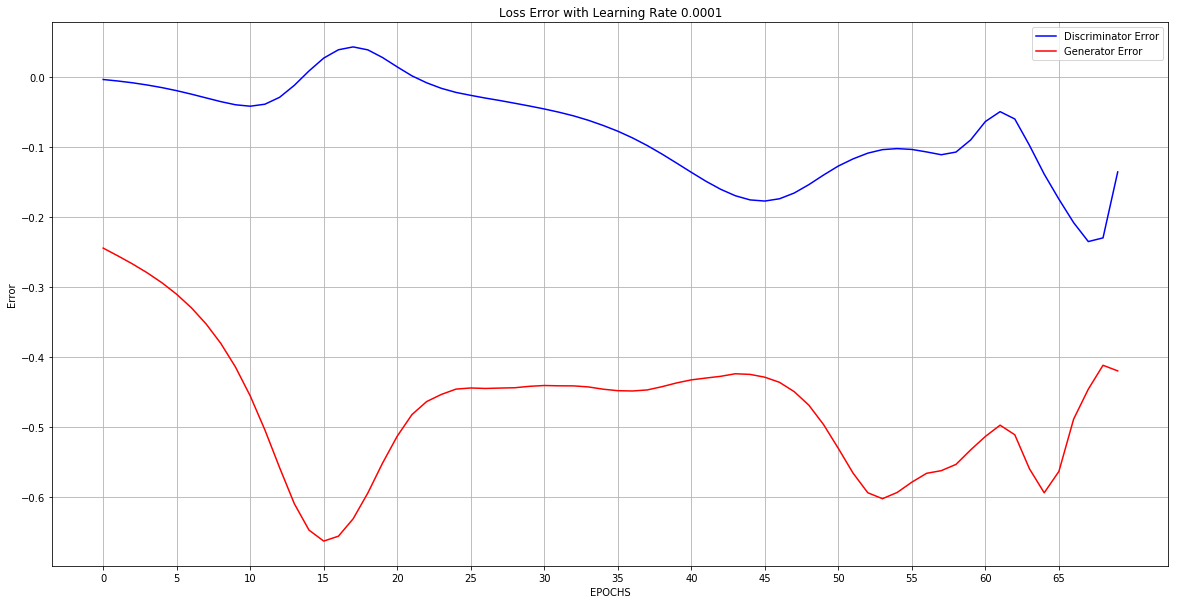

In [260]:
t=np.arange(epochs)
plt.figure(figsize=(20,10))
plt.title('Loss Error with Learning Rate {}'.format(lr))
plt.plot(t,Daverageloss,color='b',label='Discriminator Error')
plt.plot(t,Gaverageloss,color='r',label='Generator Error')
plt.xticks(np.arange(0,epochs,5))
plt.xlabel('EPOCHS')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

In [242]:
'''
H=np.reshape(samples,(batch_size*num_batches,32,32,3))
import tensorflow as tf     
y = images[:50]
y_ = H[:50]

con = tf.confusion_matrix(labels=y_, predictions=y )
sess = tf.Session()
with sess.as_default():
        print(sess.run(con))
'''

'\nH=np.reshape(samples,(batch_size*num_batches,32,32,3))\nimport tensorflow as tf     \ny = images[:50]\ny_ = H[:50]\n\ncon = tf.confusion_matrix(labels=y_, predictions=y )\nsess = tf.Session()\nwith sess.as_default():\n        print(sess.run(con))\n'

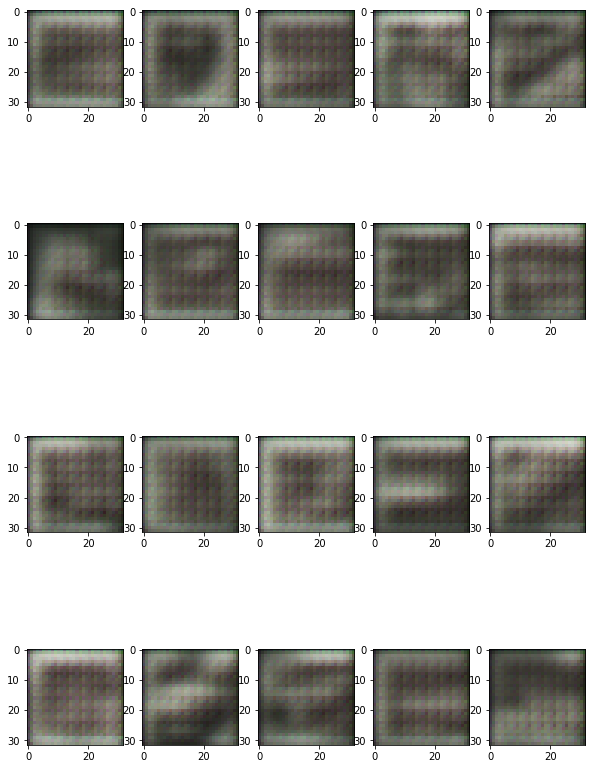

In [243]:
#H=np.reshape(samples,(h,32,32,3))
H=samples
pred=[]
for i in range(num_batches):
    for j in range(batch_size):
        pred.append(H[i][j])
fig=plt.figure(figsize=(10, 15))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=pred[80+i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()

In [118]:
np.shape(samples)

(5, 20, 32, 32, 3)

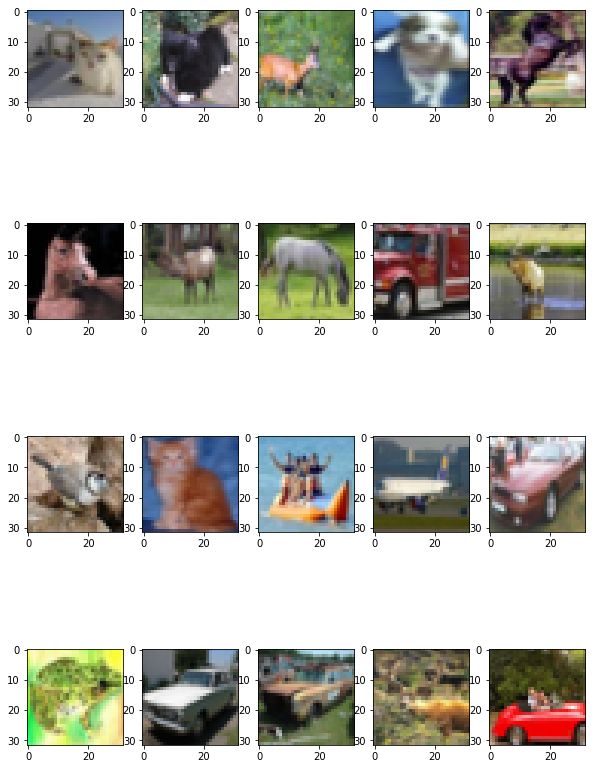

In [116]:
columns = 5
rows = 4
fig=plt.figure(figsize=(10,15))
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=images[80+i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


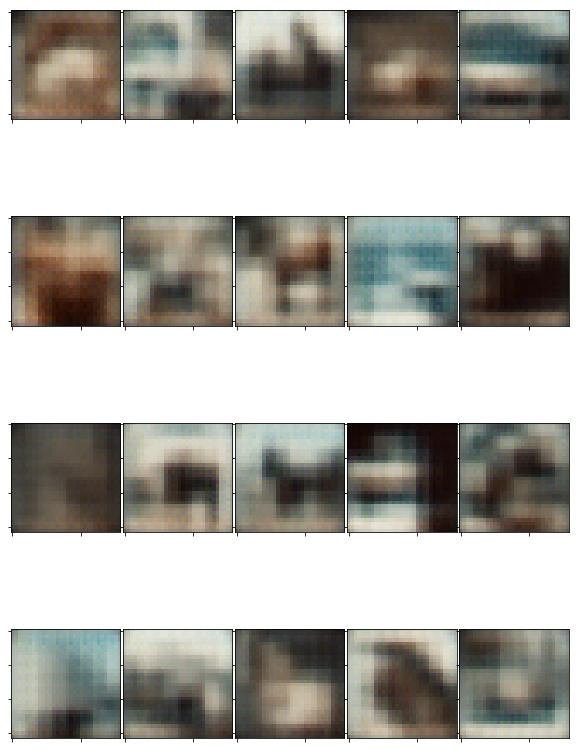

In [117]:
H=np.reshape(samples,(batch_size*num_batches,32,32,3))
import matplotlib.gridspec as gridspec
columns = 5
rows = 4
plt.figure(figsize = (10,15))
gs1 = gridspec.GridSpec(rows,columns)
gs1.update(wspace=0.025, hspace=0.05)
# set the spacing between axes.

for i in range(rows*columns):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img=H[i]
    plt.imshow(img)
plt.show()

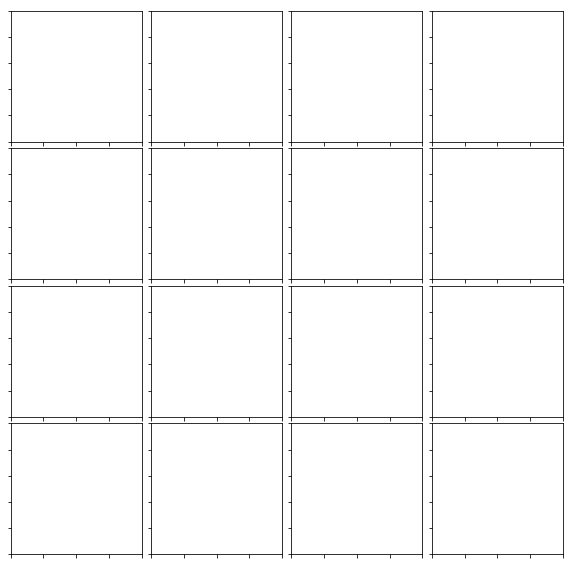

In [73]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize = (10,10))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

plt.show()